In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow_datasets as tfds

In [2]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

## DATA
- Data is generated in Lorenz_data_creation.ipynb
- 4D Data (t,x,y,z)
- Data is normalized with respect to max(abs())

In [3]:
mydf = np.genfromtxt('CSV/lorenz_normalized.csv',delimiter=',')
time = mydf[0, :]
mydf = mydf[1:, :]
print("Shape of discrete time step array ", time.shape)
print("Shape of solution array: ", mydf.shape)

Shape of discrete time step array  (10000,)
Shape of solution array:  (3, 10000)


## Data Preprocessing
- training/ testation split 70/30

In [4]:
def create_training_split(df, ratio=0.7):
    len_df = len(df)
    train = np.array(df[0:int(len_df*ratio)])
    test = np.array(df[int(len_df*ratio):])
    return train, test
def df_training_split(df, ratio=0.7):
    len_df_col = df.shape[1]
    train = np.array(df[:, 0:int(len_df_col*ratio)])
    test = np.array(df[:, int(len_df_col*ratio):])
    return train, test

In [5]:
df_train, df_test = df_training_split(mydf)
time_train, time_test = create_training_split(time, ratio=0.7)
x_train, x_test = create_training_split(mydf[0,:], ratio=0.7)
y_train, y_test = create_training_split(mydf[1, :], ratio=0.7)
z_train, z_test = create_training_split(mydf[2, :], ratio=0.7)

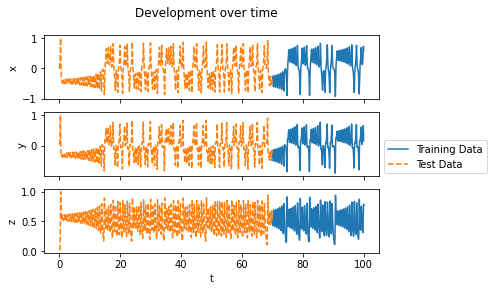

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)  # , figsize=(15, 15))
fig.suptitle('Development over time')
ax1.plot(time_test, x_test, time_train, x_train, '--')
ax1.set_ylabel('x')
ax2.plot(time_test, y_test, time_train, y_train, '--')
ax2.set_ylabel('y')
ax3.plot(time_test, z_test,label='Training Data')
ax3.plot(time_train, z_train, '--', label='Test Data')
ax3.set_ylabel('z')
ax3.set_xlabel('t')
ax3.legend(loc='center left', bbox_to_anchor=(1, 1.5))

### Windowing
- split the sequential data into windows to be fed into the network in batches
- Batch size of 32, Window size of 50, 3D entries

In [7]:
# Transposition needed for windowing of 3D data
df_train_transposed = df_train.transpose()
df_test_transposed = df_test.transpose()

In [8]:
def create_df_3d(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    #dataset = dataset.shuffle(7).map(lambda window: (window[:-1], window[-1]))#separates each window into features and label (next/last value)
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.padded_batch(batch_size, padded_shapes=([None, 3],[None]))
    return dataset

In [9]:
window_size=50
batch_size=32
shuffle_buffer_size = df_train.shape[0]
train_dataset = create_df_3d(df_train_transposed, window_size, batch_size, shuffle_buffer_size)
test_dataset = create_df_3d(df_test_transposed, window_size, batch_size, 1)

## MODEL & TRAINING
- build LSTM (same dim as window = 50)
- train LSTM (epochs?)

In [10]:
for example_inputs, example_labels in train_dataset.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 50, 3)
Labels shape (batch, time, features): (32, 3)


2022-01-24 11:37:58.379861: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [13]:
model = Sequential()
model.add(LSTM(50, activation='relu'))
model.add(Dense(3))
model.compile(loss='mse', optimizer='adam')
# fit network


In [167]:
model.fit(train_dataset, epochs=200, batch_size=batch_size)
model.summary()

Epoch 1/200
218/218 [==============================] - 2s 10ms/step - loss: 5.2691e-05
Epoch 2/200
218/218 [==============================] - 2s 9ms/step - loss: 2.6186e-05
Epoch 3/200
218/218 [==============================] - 2s 9ms/step - loss: 2.7963e-05
Epoch 4/200
218/218 [==============================] - 2s 9ms/step - loss: 1.5571e-05
Epoch 5/200
218/218 [==============================] - 2s 9ms/step - loss: 2.0125e-05
Epoch 6/200
218/218 [==============================] - 2s 9ms/step - loss: 9.4524e-05
Epoch 7/200
218/218 [==============================] - 2s 9ms/step - loss: 2.0528e-05
Epoch 8/200
218/218 [==============================] - 2s 9ms/step - loss: 2.5569e-05
Epoch 9/200
218/218 [==============================] - 2s 9ms/step - loss: 1.3176e-05
Epoch 10/200
218/218 [==============================] - 2s 10ms/step - loss: 2.1033e-05
Epoch 11/200
218/218 [==============================] - 2s 9ms/step - loss: 3.2710e-05
Epoch 12/200
218/218 [============================

## EVALUATE
Use the LSTM model to predict and plot the testation data. 

In [168]:
def create_window_closed_loop(test_data, iteration, pred=np.array([])):
    if iteration == 0:
        print("no network prediction yet")
        return test_data[:50, :].reshape(1, 50, 3)
    if iteration < 50:
        n_pred = pred.shape[0]
        idx_test_entries = iteration + 50 - n_pred  # end index of entries from the test data, 
        test_data = test_data[iteration: idx_test_entries , :]
        return np.append(test_data, pred, axis=0).reshape(1, 50, 3)
    else:
        return pred[-50:,:].reshape(1, 50, 3)

def add_new_pred(pred_old, pred_new):
    return np.append(pred_old,pred_new, axis=0)

In [169]:
test_window = create_window_closed_loop(df_test.transpose(), 0)
predictions = model.predict(test_window)
for iteration in range(1,2950):
    test_window = create_window_closed_loop(df_test.transpose(), iteration, predictions)
    new_pred = model.predict(test_window)
    predictions = add_new_pred(predictions, new_pred)
predictions.shape

no network prediction yet


(2950, 3)

In [197]:
def compute_lyapunov_time_arr(time_vector, c_lyapunov=0.90566):
    t_lyapunov = 1/c_lyapunov
    lyapunov_time = (time_vector[50:]-time_vector[0])/t_lyapunov
    return lyapunov_time

In [198]:
lyapunov_time = compute_lyapunov_time_arr(time_test)
print(lyapunov_time.shape)

(2950,)


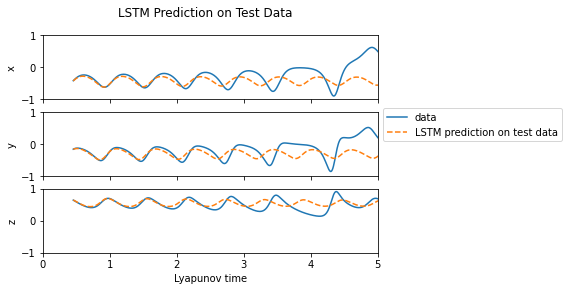

In [206]:
pred_closed_loop = predictions
test_time_end = 50 +len(predictions)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, facecolor="white")#, figsize=(15, 15))
fig.suptitle('LSTM Prediction on Test Data')
ax1.plot(lyapunov_time[:test_time_end],x_test[50:test_time_end], label='data')
ax1.plot(lyapunov_time[:test_time_end],pred_closed_loop[:,0],'--', label='RNN prediction on test data')
ax1.set_ylabel('x')

ax2.plot(lyapunov_time[:test_time_end],y_test[50:test_time_end], label='data')
ax2.plot(lyapunov_time[:test_time_end],pred_closed_loop[:,1],'--', label='RNN prediction on test data')
ax2.set_ylabel('y')
ax3.plot(lyapunov_time[:test_time_end],z_test[50:test_time_end], label='data')
ax3.plot(lyapunov_time[:test_time_end],pred_closed_loop[:,2],'--', label='LSTM prediction on test data')
ax3.set_ylabel('z')
ax3.set_xlabel('Lyapunov time')
ax3.set_ylim(-1,1)
ax3.set_xlim(0,5)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


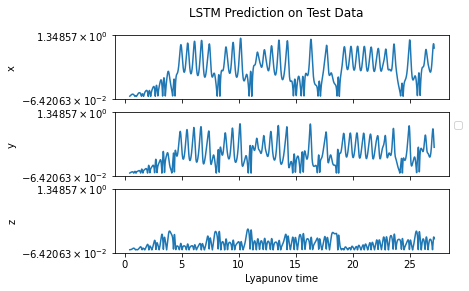

In [219]:
error_lyapunov_time = np.abs(df_test_transposed[50:, :] - predictions) 
test_time_end = 50 +len(predictions)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)#, figsize=(15, 15))
fig.suptitle('LSTM Prediction on Test Data')
ax1.plot(lyapunov_time[:test_time_end],error_lyapunov_time[:,0])
ax1.set_ylabel('x')
ax2.plot(lyapunov_time[:test_time_end],error_lyapunov_time[:,1])
ax2.set_ylabel('y')
ax3.plot(lyapunov_time[:test_time_end],error_lyapunov_time[:,2])
ax3.set_ylabel('z')
ax3.set_xlabel('Lyapunov time')
ax3.set_yscale('symlog')
#ax3.set_ylim(-0.1,10)
#ax3.set_xlim(0,5)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
plt.show()

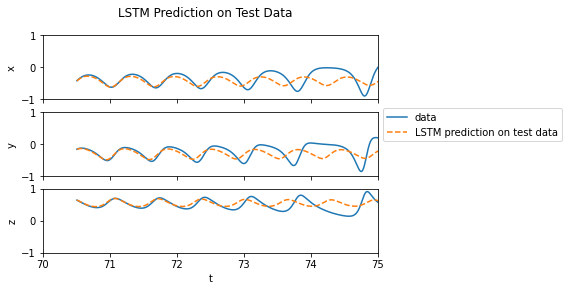

In [207]:
pred_closed_loop = predictions
test_time_end = 50 +len(predictions)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, facecolor="white")#, figsize=(15, 15))
fig.suptitle('LSTM Prediction on Test Data')
ax1.plot(time_test[50:test_time_end],x_test[50:test_time_end], label='data')
ax1.plot(time_test[50:test_time_end],pred_closed_loop[:,0],'--', label='RNN prediction on test data')
ax1.set_ylabel('x')

ax2.plot(time_test[50:test_time_end],y_test[50:test_time_end], label='data')
ax2.plot(time_test[50:test_time_end],pred_closed_loop[:,1],'--', label='RNN prediction on test data')
ax2.set_ylabel('y')
ax3.plot(time_test[50:test_time_end],z_test[50:test_time_end], label='data')
ax3.plot(time_test[50:test_time_end],pred_closed_loop[:,2],'--', label='LSTM prediction on test data')
ax3.set_ylabel('z')
ax3.set_xlabel('t')
ax3.set_ylim(-1,1)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
ax3.set_xlim(70,75)
plt.show()


In [171]:
forecast=model.predict(test_dataset) 

In [172]:
testation_filepath = 'Results/prediction_testation'

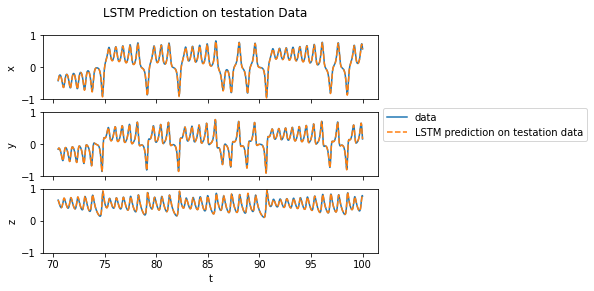

In [182]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)#, figsize=(15, 15))
fig.suptitle('LSTM Prediction on testation Data')
ax1.plot(time_test[50:],x_test[50:], label='data')
ax1.plot(time_test[50:],forecast[:,0],'--', label='RNN prediction on test data')
ax1.set_ylabel('x')
ax2.plot(time_test[50:],y_test[50:], label='data')
ax2.plot(time_test[50:],forecast[:,1],'--', label='RNN prediction on test data')
ax2.set_ylabel('y')
ax3.plot(time_test[50:],z_test[50:], label='data')
ax3.plot(time_test[50:],forecast[:,2],'--', label='LSTM prediction on test data')
ax3.set_ylabel('z')
ax3.set_xlabel('t')
ax3.set_ylim(-1,1)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
#fig.savefig(testation_filepath, dpi=1000, facecolor="w")

In [181]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['figure.facecolor']='white'

In [ ]:
err = df_test_transposed[50:, :] - forecast
err.shape

(2950, 3)

In [ ]:
error_filepath = 'Results/absolute_error'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


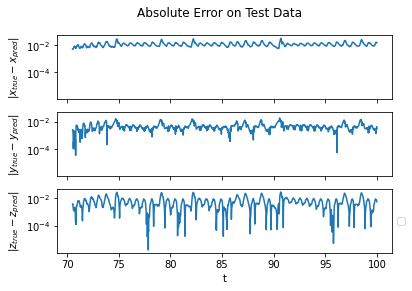

In [204]:
abs_error = np.abs(df_test_transposed[50:, :] - forecast)

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)#, figsize=(15, 15))
fig.suptitle('Absolute Error on Test Data')
ax1.plot(time_test[50:], abs_error[:, 0])
ax1.set_ylabel(r'$|x_{true}-x_{pred}|$')
ax1.set_yscale('log')
ax2.plot(time_test[50:], abs_error[:, 1])
ax2.set_ylabel(r'$|y_{true}-y_{pred}|$')
ax2.set_yscale('log')
ax3.plot(time_test[50:], abs_error[:, 2])
ax3.set_ylabel(r'$|z_{true}-z_{pred}|$')
ax3.set_xlabel('t')
ax3.set_yscale('log')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#fig.savefig(error_filepath, dpi=1000, facecolor="w")